### We can get the LUT force info from the following sources
* Matlab binary file (individual components)
* EFD (only total forces) - we have confirmed that this agrees with binary file in OL_stroke.ipynb
* aggregate from csv files 

### In this notebook, we compare binary file LUT with Harris csv files, or zenith angle = 0 only (M2 facing down)
We use the same data as in a01_OL_stroke.ipynb

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
start = Time('2020-03-05T22:27:00') #this is UTC
end = Time('2020-03-05T22:38:00') 

In [3]:
mat = scipy.io.loadmat('mat/0305/CellTelemetry_2020-03-05_203926_002.mat')
print(mat['data'].dtype.names)
mdata = mat['data']  # variable in mat file
mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
ndata = {n: mdata[n][0, 0] for n in mdtype.names}
t = [datetime.strptime(ts[0][0], '%d-%b-%Y %H:%M:%S.%f') for ts in ndata['timestamp']]
t = np.array([ti+ timedelta(hours=4, minutes=3, seconds=-5) for ti in t]) #convert to utc, 4 hours ahead of Rochester
columns = [n for n, v in ndata.items()]
nonHP = [i for i in range(78) if i+1 not in ndata['hp'][0,:]]
nonHPa = [i for i in range(72) if i+1 not in ndata['hp'][0,:]] #a for axial actuator only

def insertHPColumns(a):
    [n1, n2] = a.shape
    b = np.zeros((n1, n2+6))
    ii = 0
    for i in range(n2+6):
        if i in nonHP:
            b[:,i] = a[:,ii]
            ii += 1
        else:
            b[:,i] = 0
    return b

ndata['f_hp'] = insertHPColumns(ndata['f_hp'])
ndata['f_error'] = insertHPColumns(ndata['f_error'])

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [4]:
# cut out only the time period we are interested in
idx = (t>start) & (t<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = t[idx]

### In a02_check_telemetry.ipynb, we've checked that all the LUT components stay constant during this test (modulo noise)
We only replot f_e below

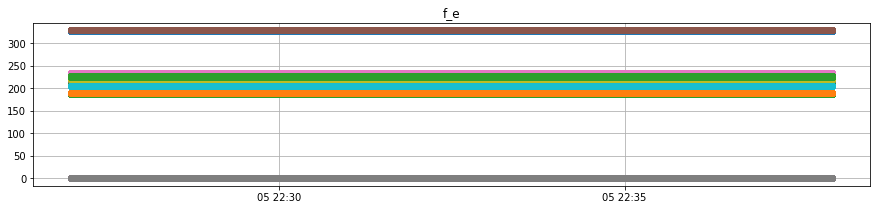

In [5]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(t, data['f_e'],'-o')
plt.title('f_e')
plt.grid() 

#### FinalHandingLUTs vs FinalOpticalLUTs 
* https://github.com/lsst-ts/ts_mtm2_cell/tree/master/configuration/lsst-m2/config/parameter_files/luts
* There are 8 files in each subfolder: FinalHandingLUTs vs FinalOpticalLUTs. The only file that is different is F_F.csv
* This is easily understandable, because the optical LUT cares about mirror shape at any zenith angle. While the other one is used for on-cart rotation.
* Which one did we use for the test? Te-Wei says we used HandlingLUTs.
* Do we know how to switch? Yes. By the high level configuration file.

In [6]:
dfe = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_E.csv')
FE = np.float64(dfe)
df0 = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_0.csv')
F0 = np.float64(df0)
dff = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_F.csv')
FF = np.float64(dff)
dfa = pd.read_csv('harrisLUT/FinalHandlingLUTs/F_A.csv')
FA = np.float64(dfa)
zangle = np.float64(dfe.keys())
dtr = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tr.csv', header=None)
Tr = np.float64(dtr)
dtu = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tu.csv', header=None)
Tu = np.float64(dtu)
dtx = pd.read_csv('harrisLUT/FinalHandlingLUTs/Tx.csv', header=None)
Tx = np.float64(dtx)
dty = pd.read_csv('harrisLUT/FinalHandlingLUTs/Ty.csv', header=None)
Ty = np.float64(dty)

In [23]:
#73 columns, each column for one angle (-270 - 90)
print(FE.shape, F0.shape, FF.shape, FA.shape, Tr.shape, Tu.shape, Tx.shape, Ty.shape)
#FA (actuator weight component) is the only one that includes the tangent links. Why???

(72, 73) (72, 73) (72, 73) (78, 73) (72, 1) (72, 1) (72, 1) (72, 1)


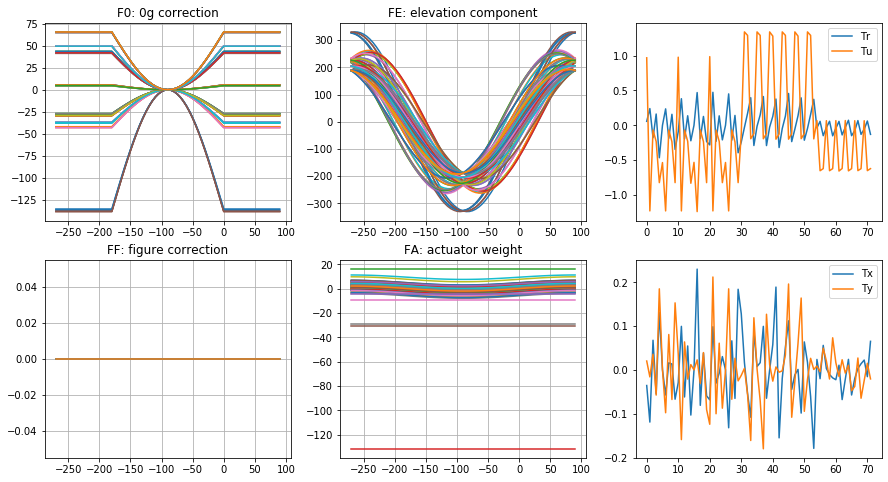

In [8]:
# The below refers to the correctability document from Harris -
# according to Harris page 26, 0-90 is telescope operating range.
# according to Harris page 32, 0 deg is horizon, 90 deg is zenith.
# positive z goes into M2, to the sky. The angle refers to the z axis.
# Harris page 29 shows it cares a lot about zenith, which is z pointing up (90 deg from x axis.)

fig, ax = plt.subplots(2,3, figsize=(15,8))
s1 = ax[0][0].plot(zangle, F0.transpose())
ax[0][0].set_title('F0: 0g correction')
ax[0][0].grid()
s2 = ax[0][1].plot(zangle, FE.transpose())
ax[0][1].set_title('FE: elevation component')
ax[0][1].grid()
s3 = ax[1][0].plot(zangle, FF.transpose())
ax[1][0].set_title('FF: figure correction')
ax[1][0].grid()
s4 = ax[1][1].plot(zangle, FA.transpose())
ax[1][1].set_title('FA: actuator weight')
ax[1][1].grid()

ax[0][2].plot(Tr, label='Tr')
ax[0][2].plot(Tu, label='Tu')
ax[0][2].legend()
ax[1][2].plot(Tx, label='Tx')
ax[1][2].plot(Ty, label='Ty')
ax[1][2].legend();

In [12]:
#this is an old matrix I got from John ~2 years ago.
# tempInv = pd.read_csv('harrisLUT/temp_inv_20171027.csv', header=None)
# It seems to match what Te-Wei found in Harris' code
#Temperature distribution matrix:
tempInv = np.loadtxt('harrisLUT/temp_inv.txt')

In [13]:
tempInv.shape

(4, 12)

In [12]:
data['temp_proc'][0,:]

array([19.67599869, 19.71090126, 19.70919991, 19.70830154, 23.62399864,
       24.51980019, 26.26050186, 24.0936985 , 19.73390007, 19.7628994 ,
       19.71069908, 19.71310043, 19.70949936, 19.61989975, 19.72119904,
       19.61470032])

### Next, the question is, how are the 16 temps ordered. Accordiing to Te-Wei
* https://github.com/lsst-ts/ts_mtm2/issues/17
The input temperature sensor data is an 16 element array (what you get from the binary file). The code takes the following index: [1, 2, 3, 12, 9, 8, 13, 14, 15, 11, 10, 0]. (index begins from 0). The column is "LG2-2, LG2-3, LG2-4, LG3-1, LG4-2, LG4-1, LG3-2, LG3-3, LG3-4, LG4-4, LG4-3, LG2-1" based on the comment in code.
* https://jira.lsstcorp.org/browse/DM-23523?filter=17301 The above are consistent with the numbering here (This is how our array map to the display on GUI) 
0               LG2-1
1               LG2-2
2               LG2-3
3               LG2-4
4               Intake #1
5               Exhaust #1
6               Exhaust #2
7               Intake #2
8                LG4-1
9                LG4-2
10              LG4-3
11              LG4-4
12              LG3-1
13              LG3-2
14              LG3-3
15              LG3-4
* old email attachment (M2_temperature_correction_force_calculation.pdf) has temp sensor 1-12 location. But this is different from page 36 of 03_M2_correctability_analysis.pdf. Very Different!

In [14]:
idx = [1, 2, 3, 12, 9, 8, 13, 14, 15, 11, 10, 0]
myt= np.array([data['temp_proc'][0,i] for i in idx])

In [15]:
# I even wanted to try out all the permutations, and see which one matches the best. 12! takes a long time to do!
#import itertools
#counter = 0
#for ii in list(itertools.permutations(idx)):
#    counter += 1
#    if counter>2:
#        break
#    myt1= np.array([data['temp_proc'][0,i] for i in ii])
#    #tempInv.dot(myt1-21)
#    print(myt1)

In [16]:
np.sum(tempInv, axis=1)

array([ 0.00000000e+00, -8.32667268e-17,  6.93889390e-18,  1.00040000e+00])

#### What the above tells us is that, if the temperature is perfectly uniform, = T0 everywhere, but different from reference T (T_ref), then only the last row matters.
* So the last row has to be about uniformity. 
* Most likely the order in M2_temperature_correction_force_calculation.pdf, is right, it is Tr, Tx, Ty, Tu (Te-Wei confirmed this)
* what is T_ref? if it is the average of the measured T, any uniform T0 will have no effect. So it cannot be right.
* Acoording to M2_temperature_correction_force_calculation.pdf, we simply use the measured T in the multiplication. In this case, any deviation from 0 C will produce non-zero F_Tu. is that really what they meant? the thermal FEA was done at 0 C ?
* based on further numerical check, T_ref = 21 C makes the csv-based calculations agree with binary telemetry. (Te-Wei confirmed this)

In [17]:
data['T_u'][0,:]/Tu[:,0]

array([-1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32401306,
       -1.32401306, -1.32401306, -1.32401306, -1.32401306, -1.32

In [18]:
tempInv.dot(myt-21)

array([ 0.02740649, -0.02334037, -0.02098158, -1.32401306])

Great. The last number matches above.

In [20]:
tref = 21 #deg C. 
tcoef = tempInv.dot(myt-tref)

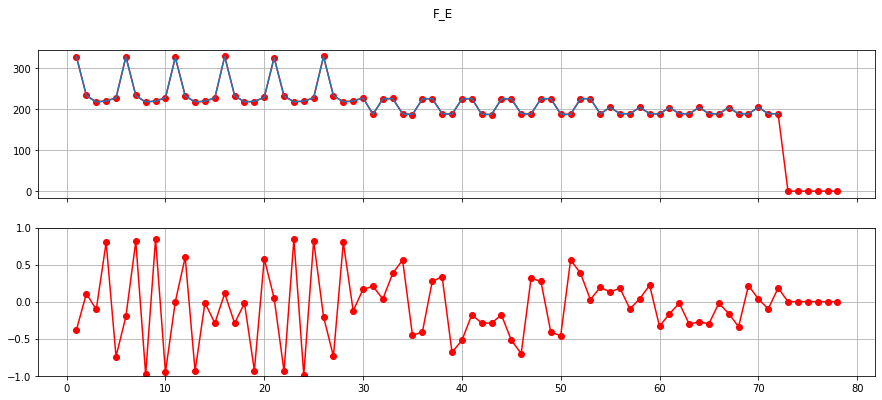

In [21]:
x0 = np.linspace(1,78,78)
x00 = np.linspace(1,72,72)
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_e'][0,:],'-ro')
ax[0].plot(x00, FE[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_e'][0,:]-np.concatenate((FE[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_E');

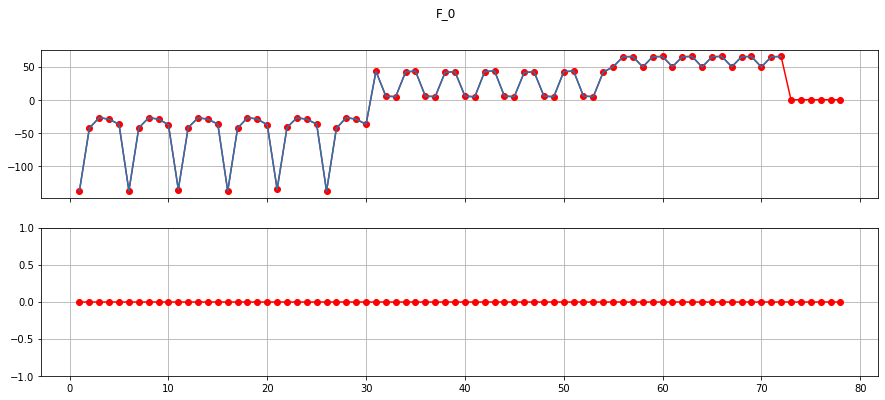

In [22]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_0'][0,:],'-ro')
ax[0].plot(x00, F0[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_0'][0,:]-np.concatenate((F0[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_0');

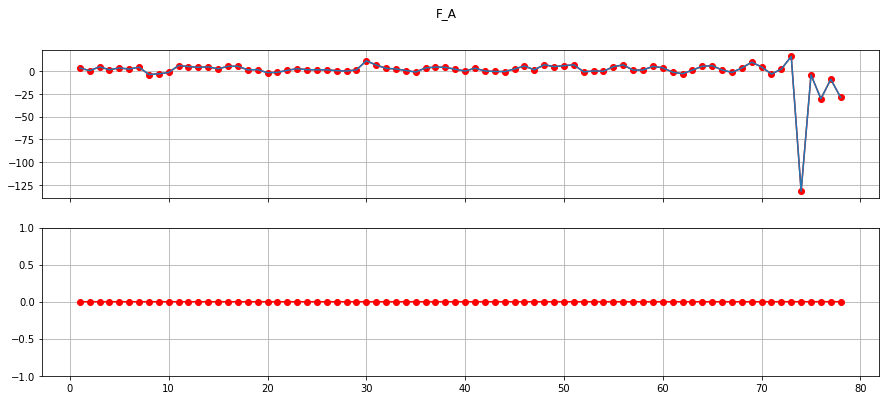

In [24]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_a'][0,:],'-ro')
ax[0].plot(x0, FA[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_a'][0,:]-FA[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_A');

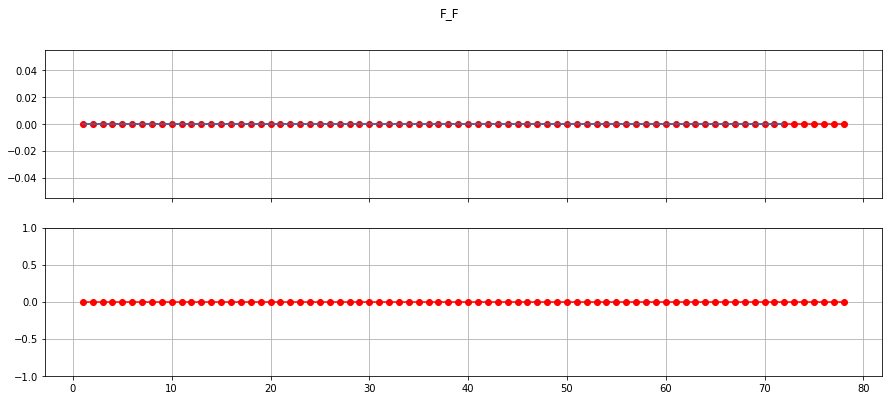

In [25]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x0, data['f_f'][0,:],'-ro')
ax[0].plot(x00, FF[:,0])
ax[0].grid()
ax[1].plot(x0, data['f_f'][0,:]-np.concatenate((FF[:,0], np.zeros(6))),'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_F');

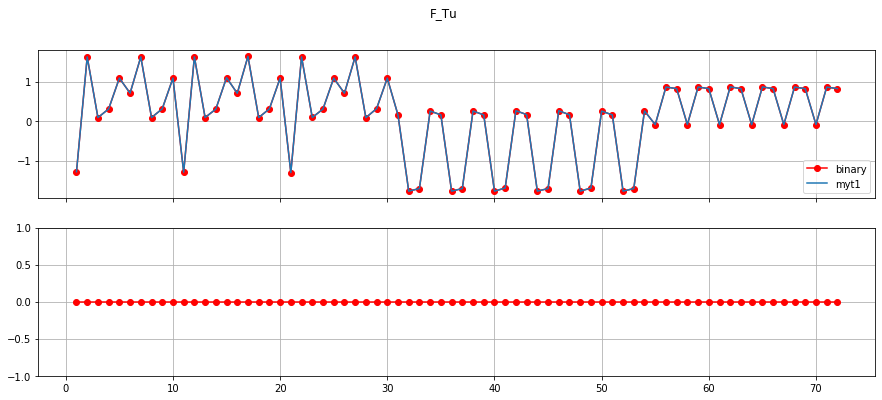

In [26]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_u'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[3]*Tu, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_u'][0,:]-tcoef[3]*Tu[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tu');

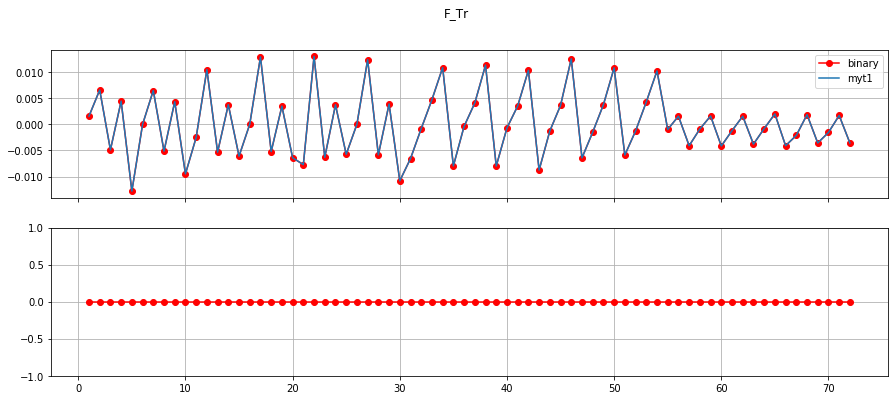

In [27]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_r'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[0]*Tr, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_r'][0,:]-tcoef[0]*Tr[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tr');

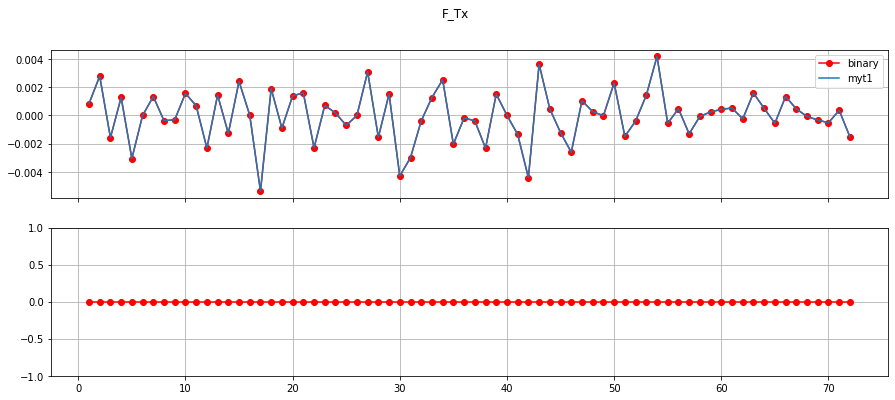

In [28]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_x'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[1]*Tx, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_x'][0,:]-tcoef[1]*Tx[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Tx');

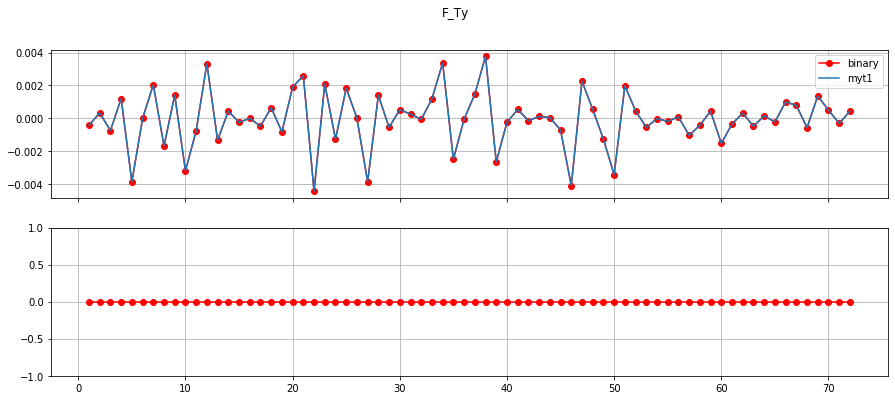

In [29]:
fig, ax = plt.subplots(2,1, sharex = True, figsize=(15,6))
ax[0].plot(x00, data['T_y'][0,:],'-ro', label='binary')
ax[0].plot(x00, tcoef[2]*Ty, label='myt1')
ax[0].legend()
ax[0].grid()
ax[1].plot(x00, data['T_y'][0,:]-tcoef[2]*Ty[:,0],'-ro')
ax[1].grid()
ax[1].set_ylim([-1,1])
plt.suptitle('F_Ty');

### The below confirms that f_cmd is the total LUT force.

act#6, F_HC[0] = 0.00, residual[0] = -0.00
act#16, F_HC[0] = 0.00, residual[0] = -0.00
act#26, F_HC[0] = 0.00, residual[0] = -0.00


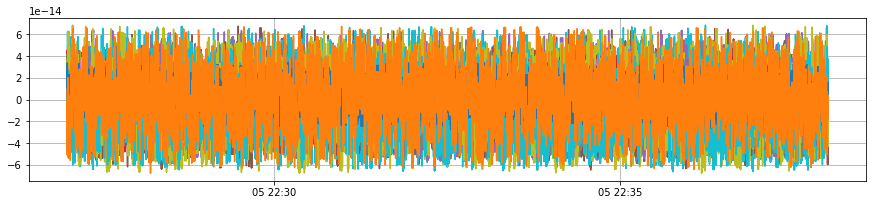

In [30]:
fig, ax = plt.subplots(figsize=(15,3))
for i in range(72):
    aa = (data['f_cmd'][:,i] - data['f_e'][:,i] - data['f_0'][:,i]-data['f_a'][:,i]-data['f_f'][:,i]
        -data['T_r'][:,i]-data['T_x'][:,i] -data['T_y'][:,i] -data['T_u'][:,i])
    plt.plot(t, aa)
    if (aa[0]>10) or i==5 or i==15 or i==25:
        print('act#%d, F_HC[0] = %.2f, residual[0] = %.2f'%(i+1, data['f_hp'][0,i], aa[0]))
plt.grid()

### Summary:
* The LUT matches expectation at zenith angle = 0.
* f_cmd is indeed the LUT forces.
* Need to know the temperature sensor layout and ordering, in order to know how to use the LUT exactly.